In [2]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
# === LOAD & PREP DATA ===
games = pd.read_csv("games_full.csv")
games = games.dropna(subset=['title'])
all_titles = sorted(games['title'].drop_duplicates().tolist())
games_cluster_new = games

In [4]:
# Fill missing categorical values with "Unknown" on dev, pub and genres
games_cluster_new['developers'] = games_cluster_new['developers'].fillna('Unknown_dev')
games_cluster_new['publishers'] = games_cluster_new['publishers'].fillna('Unknown_pub')
games_cluster_new['genres'] = games_cluster_new['genres'].fillna('Unknown_gen')
PS_Box_drop = ['PS', 'xBox']  
games_cluster_new = games_cluster_new.drop(columns=PS_Box_drop)

In [5]:
games_cluster_new.head()

,title,gameid,developers,publishers,genres,supported_languages,release_date,Steam
0,Fieldrunners 2,215710,['Subatomic Studios LLC'],['Subatomic Studios LLC'],"['Action', 'Strategy', 'Casual']",['English'],2013-01-10,Yes
1,Goddess detective 2,2475270,['2024-NGame'],['2024-NGame'],['Indie'],"['English', 'Russian', 'Simplified Chinese', '...",2023-08-31,Yes
2,Magic pal and great,3203600,['神奇伙伴与大圣'],['神奇伙伴与大圣'],"['Action', 'Adventure', 'Casual', 'RPG']","['English', 'Simplified Chinese']",2024-10-19,Yes
3,Promise with My Sister,2843130,['Carnival Pepper'],['Carnival Pepper'],"['Casual', 'Indie', 'RPG', 'Strategy']","['Japanese', 'Simplified Chinese', 'Traditiona...",2024-05-09,Yes
4,Wanba Warriors,1021770,['Wanba Studio'],['Wanba Studio'],"['Action', 'Indie']","['English', 'Simplified Chinese', 'Japanese', ...",2020-03-25,Yes


In [6]:
# Replace NaN values on Steam cols with the most frequent value of Yes (1)
if games_cluster_new['Steam'].isnull().sum() > 0:  
    most_frequent_value = games_cluster_new['Steam'].mode()[0] 
    games_cluster_new['Steam'].fillna(most_frequent_value, inplace=True)

In [7]:
# changing Steam value to binary
binary_features = ['Steam']
for feature in binary_features:
    games_cluster_new[feature] = games_cluster_new[feature].map({'Yes': 1, 'No': 0})

In [8]:
# Ensure release_date is in datetime format
games_cluster_new['release_date'] = pd.to_datetime(games_cluster_new['release_date'], errors='coerce')

# reference date beginning of the Unix Epoch time and calculating days in b/n 
ref_date = datetime(1970, 1, 1)
games_cluster_new['days_since_release'] = (games_cluster_new['release_date'] - ref_date).dt.days
games_cluster_new = games_cluster_new.dropna(subset=['days_since_release'])
games_cluster_new = games_cluster_new.drop('release_date', axis=1)
# Scaling 
scaler = StandardScaler()
games_cluster_new['release_year_scaled'] = scaler.fit_transform(games_cluster_new[['days_since_release']])

In [9]:
# drop days_since_release
games_cluster_new = games_cluster_new.drop('days_since_release', axis=1)

In [10]:
games_cluster_new.head()

,title,gameid,developers,publishers,genres,supported_languages,Steam,release_year_scaled
0,Fieldrunners 2,215710,['Subatomic Studios LLC'],['Subatomic Studios LLC'],"['Action', 'Strategy', 'Casual']",['English'],1,-2.585753
1,Goddess detective 2,2475270,['2024-NGame'],['2024-NGame'],['Indie'],"['English', 'Russian', 'Simplified Chinese', '...",1,0.848105
2,Magic pal and great,3203600,['神奇伙伴与大圣'],['神奇伙伴与大圣'],"['Action', 'Adventure', 'Casual', 'RPG']","['English', 'Simplified Chinese']",1,1.214914
3,Promise with My Sister,2843130,['Carnival Pepper'],['Carnival Pepper'],"['Casual', 'Indie', 'RPG', 'Strategy']","['Japanese', 'Simplified Chinese', 'Traditiona...",1,1.070842
4,Wanba Warriors,1021770,['Wanba Studio'],['Wanba Studio'],"['Action', 'Indie']","['English', 'Simplified Chinese', 'Japanese', ...",1,-0.260275


In [11]:
# Count the number of unique genres with List of unique genres
unique_genres_count = games_cluster_new['genres'].nunique()
print(f"Number of unique genres: {unique_genres_count}")
unique_gen = games_cluster_new['genres'].unique()
print(f"Unique genres: {unique_gen}")


Number of unique genres: 2861
Unique genres: ["['Action', 'Strategy', 'Casual']" "['Indie']"
 "['Action', 'Adventure', 'Casual', 'RPG']" ...
 "['Action', 'Adventure', 'Indie', 'Racing', 'RPG', 'Early Access']"
 "['Casual', 'Free To Play', 'Indie', 'Racing', 'Simulation', 'Sports', 'Strategy']"
 "['Indie', 'Racing', 'Game Development']"]


In [12]:
# List the unique developers with no of unique devs
unique_devs = games_cluster_new['developers'].unique()
print(f"Unique genres: {unique_devs}")
num_unique_devs = games_cluster_new['developers'].nunique()
print(f"Number of unique developers: {num_unique_devs}")

Unique genres: ["['Subatomic Studios LLC']" "['2024-NGame']" "['神奇伙伴与大圣']" ... "['绝汪']"
 "['Jeroen Wimmers']" "['Nuclear Tales']"]
Number of unique developers: 52683


In [13]:
## Top 100 genres and then replace the less frequent with other. 
## this help to reduce high cardinality of unique genres: 2861 to focus on top 100 genres
genre_counts = games_cluster_new['genres'].value_counts()
top_100_genres = genre_counts.nlargest(100).index 
games_cluster_new['genres'] = games_cluster_new['genres'].apply(lambda x: x if x in top_100_genres else 'Other')

print("Updated genres top 100 genres:")
print(games_cluster_new['genres'])

Updated genres top 100 genres:
0                                    Other
1                                ['Indie']
2                                    Other
3                                    Other
4                      ['Action', 'Indie']
                       ...                
82266                                Other
82267                  ['Action', 'Indie']
82268                  ['Casual', 'Indie']
82269    ['Action', 'Indie', 'Simulation']
82270                                Other
Name: genres, Length: 82271, dtype: object


In [14]:
## Highly Correlated Features: developers and publishers overlap significantly. Developers only reatained.
## No variance on steam all list of games almost are from steam category (dropped).
## Text columns are generally unsuitable unless transformed into numerical representations 
## (title, gameid will add back after clustering)
## supported_languages filterd based on frequent 10 value and repalced the rest of the remaining rows

In [15]:
cols_to_drop = ['title','gameid','publishers','Steam','supported_languages']
games_cluster_dropped = games_cluster_new.drop(columns = cols_to_drop, axis=1)


In [16]:
games_cluster_dropped.head()

,developers,genres,release_year_scaled
0,['Subatomic Studios LLC'],Other,-2.585753
1,['2024-NGame'],['Indie'],0.848105
2,['神奇伙伴与大圣'],Other,1.214914
3,['Carnival Pepper'],Other,1.070842
4,['Wanba Studio'],"['Action', 'Indie']",-0.260275


In [17]:
games_cluster_dropped

,developers,genres,release_year_scaled
0,['Subatomic Studios LLC'],Other,-2.585753
1,['2024-NGame'],['Indie'],0.848105
2,['神奇伙伴与大圣'],Other,1.214914
3,['Carnival Pepper'],Other,1.070842
4,['Wanba Studio'],"['Action', 'Indie']",-0.260275
...,...,...,...
82266,['绝汪'],Other,1.225520
82267,['Ultimo Games'],"['Action', 'Indie']",-0.501574
82268,['Jeroen Wimmers'],"['Casual', 'Indie']",-1.260823
82269,['2nd Studio'],"['Action', 'Indie', 'Simulation']",-0.699562


In [18]:
## Top 100 developers and then replace the less frequent with beyond_100
## (to reduce high dimentionality | very high cardinality results memory run out)
dev_counts = games_cluster_new['developers'].value_counts()
top_100_dev = dev_counts.nlargest(100).index 
games_cluster_new['developers'] = games_cluster_new['developers'].apply(lambda x: x if x in top_100_dev else 'beyond_100')

print(games_cluster_new['developers'].value_counts())


beyond_100                      77608
['Choice of Games']               165
['Laush Dmitriy Sergeevich']      137
['Boogygames Studios']            132
Unknown_dev                       131
                                ...  
['Loolust']                        24
['Vidas Salavejus']                24
['Anatoliy Loginovskikh']          24
['Graphium Studio']                24
['Arc System Works']               24
Name: developers, Length: 101, dtype: int64


In [19]:
#Filter out rows with "beyond_100" developers and unknown developers
filtered_games_clu = games_cluster_new[
    (games_cluster_new['developers'] != 'beyond_100') & 
    (games_cluster_new['developers'] != 'Unknown_dev')
]
filtered_games_clu.head()

,title,gameid,developers,publishers,genres,supported_languages,Steam,release_year_scaled
46,- Am I kind-hearted? - ワタシのココロは綺麗ですか？,2050840,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Adventure'],"['English', 'French', 'Italian', 'German', 'Sp...",1,0.488368
48,- Doki Doki Family - 特異体質者のドキドキ家族生活,1961860,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Simulation'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.438871
49,- Mischief Dungeon Life - 異世界転生した俺のイタズラダンジョンライフ,1961870,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Simulation'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.438871
50,- Mischief Dungeon Life - 異世界転生した俺のイタズラダンジョンライ...,2184390,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Adventure'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.599736
51,- Mischief Dungeon Life - 異世界転生した俺のイタズラダンジョンライ...,2184420,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","[' CyberStep, Inc.']",['Adventure'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.599736


In [20]:
filtered_games_clu.tail()

,title,gameid,developers,publishers,genres,supported_languages,Steam,release_year_scaled
82087,美人姉妹と入れ替わり生活 -Becoming Your Beautiful Cousin-,2442610,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']","['Adventure', 'Casual', 'Simulation']","['English', 'French', 'Italian', 'German', 'Sp...",1,0.797724
82088,美少女ストリーマーの秘密恋愛 - Secret romance with streamer ...,2371470,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']","['Adventure', 'Casual', 'Simulation']","['English', 'French', 'Italian', 'German', 'Sp...",1,0.748227
82103,草食系男子の言いなり入院生活- A passive boy at the Huntress ...,2265010,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",Other,"['English', 'French', 'Italian', 'German', 'Sp...",1,0.656304
82222,鬼鎮村の危険な因襲 - Dangerous Village Tradition -,2612780,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']","['Adventure', 'Casual', 'Simulation']","['English', 'French', 'Italian', 'German', 'Sp...",1,0.890531
82259,～ Innocent Stuck-up Girls! ～ 肉食ギャルは清純派！？,2396860,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']","['Adventure', 'Casual', 'Simulation']","['English', 'French', 'Italian', 'German', 'Sp...",1,0.772976


In [21]:
# perform clustering on release_year_scaled as numeric feature separetely
from sklearn.cluster import MiniBatchKMeans
mini_k_release_year = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=100)
clust_release_year = mini_k_release_year.fit_predict(filtered_games_clu[['release_year_scaled']])

# Add the cluster labels back to the dataset
filtered_games_clu['Cluster_release_yr'] = clust_release_year


C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
<ipython-input-21-ff3d55624f49>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_games_clu['Cluster_release_yr'] = clust_release_year


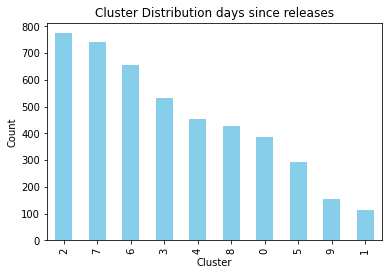

In [22]:
filtered_games_clu['Cluster_release_yr'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution days since releases')
plt.show()

In [23]:
# drop cols 'title','gameid','publishers','Steam','supported_languages','release_year_scaled'
cols_to_drop1 = ['title','gameid','publishers','Steam','supported_languages','release_year_scaled']
filtered_games_clu = filtered_games_clu.drop(columns = cols_to_drop1, axis=1)

In [24]:
filtered_games_clu.tail()

,developers,genres,Cluster_release_yr
82087,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",2
82088,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",2
82103,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",Other,2
82222,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",7
82259,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",2


In [25]:
filtered_games_clu.shape

(4532, 3)

In [26]:
## Correlation between developer and publisher
con_tab = pd.crosstab(games_cluster_new['developers'], games_cluster_new['publishers'])
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(con_tab)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")
# dropped publisher feature.

Chi-Square Statistic: 6484305.465376194, p-value: 0.0


In [27]:
# Run Clustering after encoding based on variance = 0.01 then run cluter with chunk
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
import pandas as pd

encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(filtered_games_clu[['developers', 'genres']])
encoded_columns = encoder.get_feature_names_out(['developers', 'genres'])
processed_data = pd.DataFrame(encoded_features, columns=encoded_columns)
selector = VarianceThreshold(threshold=0.01)  
reduced_features = selector.fit_transform(processed_data)
chunk_size = 10000 
clusters_list = []

for start_row in range(0, len(processed_data), chunk_size):
    chunk = processed_data[start_row:start_row + chunk_size]
    mini_kmeans = MiniBatchKMeans(n_clusters=10, random_state=0, batch_size=100)
    chunk_clusters = mini_kmeans.fit_predict(chunk)
    clusters_list.extend(chunk_clusters)

filtered_games_clu['Cluster_of_dev&Genres'] = clusters_list[:len(filtered_games_clu)]  


C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [28]:
filtered_games_clu.head()

,developers,genres,Cluster_release_yr,Cluster_of_dev&Genres
46,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,5
48,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],6,0
49,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],6,0
50,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,5
51,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,5


C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

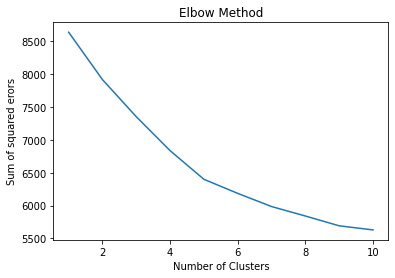

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# checking best k no using elbow
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(processed_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared erors')
plt.show()

C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

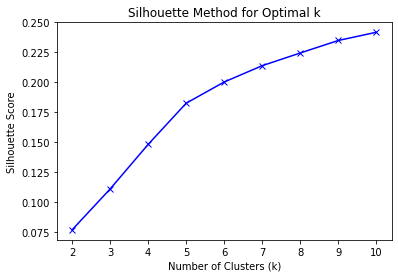

In [30]:
# score ranges from -1 (poor) to 1 (perfect clustering) best works on high cardinality data
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(processed_data)
    score = silhouette_score(processed_data, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [31]:
new_games_cluster = filtered_games_clu[['developers', 'genres']]
new_games_cluster.head()

,developers,genres
46,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure']
48,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation']
49,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation']
50,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure']
51,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure']


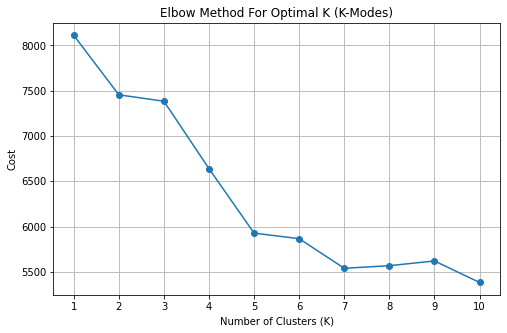

In [32]:
## K-mode ---> optimum K-values using elbow method
import pandas as pd
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
# Loop over to K = 11 values
cost = []
K = range(1, 11)  
for k in K:
    km = KModes(n_clusters=k, init="Huang", n_init=5, verbose=0)
    km.fit_predict(new_games_cluster)
    cost.append(km.cost_)

# Plotting the Elbow
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal K (K-Modes)')
plt.xticks(K)
plt.grid(True)
plt.show()


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 581, cost: 6128.0
Run 1, iteration: 2/100, moves: 16, cost: 6128.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 86, cost: 5929.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 48, cost: 6550.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 59, cost: 6486.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 119, cost: 6556.0
Best run was number 2
K-Modes Cost: 5929.0
Cluster centroids (mode values):
[["['Choice of Games']" 'Other']
 ["['Laush Dmitriy Sergeevich']" "['Casual', 'Indie']"]
 ["['Tero Lunkka', 'Valkeala Software']"
  "['Adventure', 'Casual', 'Indie']"]
 ["['Elephant Games']" "['Adventure', 'Casual']"]
 ["['Front

<ipython-input-33-707d159a8342>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_games_cluster['Cluster'] = clusters


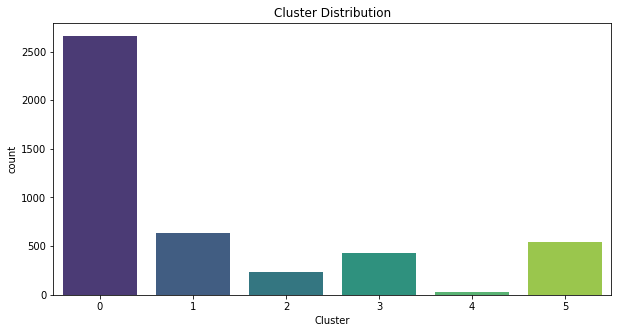

In [33]:
## Using K-modes ---> clustering categorical variables only
import pandas as pd
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import seaborn as sns
# Initialize K-Modes
km = KModes(n_clusters=6, init='Huang', n_init=5, verbose=1)
# Fit K-Modes model
clusters = km.fit_predict(new_games_cluster)
# Add cluster label back to dataframe
new_games_cluster['Cluster'] = clusters
# Evaluate K-mode
print(f"K-Modes Cost: {km.cost_}")
# Print Cluster Centers
print("Cluster centroids (mode values):")
print(km.cluster_centroids_)
# Plot: count of categories per cluster
plt.figure(figsize=(10, 5))
sns.countplot(data=new_games_cluster, x='Cluster', palette='viridis')
plt.title("Cluster Distribution")
plt.show()

In [119]:
new_games_cluster.shape


(4532, 3)

In [34]:
KModes_Cost = 5876.0
n_rows_by_features = 4532
mismatch_per_row = KModes_Cost / n_rows_by_features
mismatch_per_row
## On average, each row mismatches 1.36 fields compared to its cluster center.
## Every excution may have diffrent results

1.296557811120918

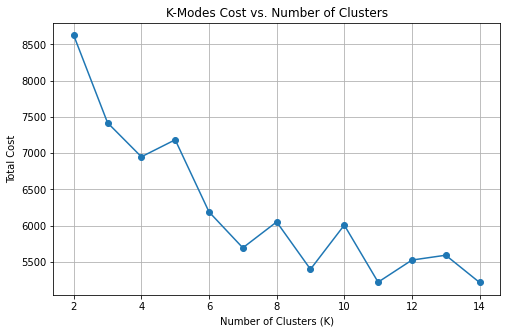

In [36]:
## ploting Kmode cost vs no of Clusters
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

costs = []
K_values = range(2, 15)

for K in K_values:
    km = KModes(n_clusters=K, init='Huang', n_init=5, verbose=0)
    km.fit_predict(new_games_cluster)
    costs.append(km.cost_)

plt.figure(figsize=(8,5))
plt.plot(K_values, costs, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Total Cost')
plt.title('K-Modes Cost vs. Number of Clusters')
plt.grid(True)
plt.show()


In [38]:
new_games_cluster.head()

,developers,genres,Cluster
46,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],0
48,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],0
49,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],0
50,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],0
51,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],0


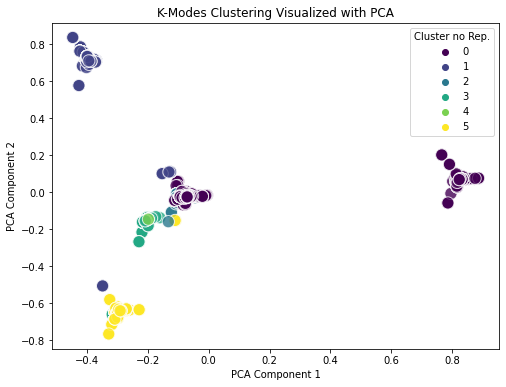

In [55]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
# One-Hot Encode for visualization
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(new_games_cluster[['developers','genres']]).toarray()
# Dim Reduction (PCA to 2D)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_data)
# Plot the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_data[:, 0], 
                y=reduced_data[:, 1], 
                hue=new_games_cluster['Cluster'], 
                palette='viridis',
                s=150,      
                alpha=0.8 )
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Modes Clustering Visualized with PCA')
plt.legend(title='Cluster no Rep.')
plt.show()

In [40]:
for cluster_num, members in new_games_cluster.groupby('Cluster'):
    print(f"\nCluster {cluster_num} Members:")
    print(members)


Cluster 0 Members:
                                         developers  \
46     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
48     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
49     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
50     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
51     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
...                                             ...   
82087  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82088  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82103  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82222  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82259  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   

                                      genres  Cluster  
46                             ['Adventure']        0  
48                            ['Simulation']        0  
49                            ['Simulation']        0  
50                             ['Adventure']        0  
51                             ['Advent

In [42]:
processed_data.shape

(4532, 187)

In [44]:
# Compute Silhouette Score (Results varies every Excution)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
# Assume df has categorical features + cluster labels
categorical_features = filtered_games_clu.drop(columns=['Cluster_release_yr','Cluster_of_dev&Genres'])
# One-hot encode
encoded_features = pd.get_dummies(categorical_features)
labels_clus = filtered_games_clu['Cluster_of_dev&Genres']
# Compute Silhouette Score
if len(set(labels_clus)) > 1:
    score = silhouette_score(encoded_features, labels_clus)
    print(f"Silhouette Score of K-means: {score:.4f}")
else:
    print("Only one cluster detected — cannot compute silhouette score.")

Silhouette Score of K-means: 0.0987


In [45]:
filtered_games_clu.head()

,developers,genres,Cluster_release_yr,Cluster_of_dev&Genres
46,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,0
48,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],6,2
49,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],6,2
50,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,0
51,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,0


In [46]:
import umap

C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


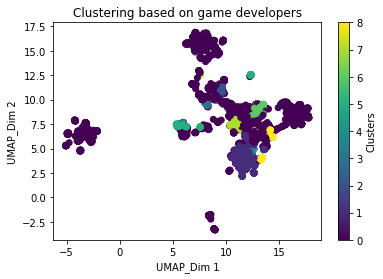

In [47]:
# Reduce to 2 dimensions using UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data_umap = reducer.fit_transform(processed_data)

plt.scatter(reduced_data_umap[:, 0], reduced_data_umap[:, 1], c=filtered_games_clu['Cluster_of_dev&Genres'], cmap='viridis')
plt.xlabel('UMAP_Dim 1')
plt.ylabel('UMAP_Dim 2')
plt.title('Clustering based on game developers')
plt.colorbar(label='Clusters')
plt.show()

In [48]:
clusters = filtered_games_clu['Cluster_of_dev&Genres'].unique()
clusters

array([0, 2, 6, 5, 1, 7, 8, 3, 4], dtype=int64)

In [49]:
print(filtered_games_clu['Cluster_of_dev&Genres'].unique())

[0 2 6 5 1 7 8 3 4]


In [50]:
# Loop through all rows to populate all 9 clusters 
for clust_id in range(10):  
    clust_members = filtered_games_clu[filtered_games_clu['Cluster_of_dev&Genres'] == clust_id]  
    print(f"Cluster {clust_id}: {len(clust_members)} members")
    print(clust_members) 
    print("\n" + "-" * 50 + "\n")  

Cluster 0: 3084 members
                                         developers  \
46     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
50     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
51     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
52     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
53     ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
...                                             ...   
81978  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82087  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82088  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82222  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   
82259  ['CyberStep, Inc.', 'Rideon Works Co. Ltd,']   

                                      genres  Cluster_release_yr  \
46                             ['Adventure']                   2   
50                             ['Adventure']                   2   
51                             ['Adventure']                   2   
52     ['Adventure', 'Casual', 'Simulation'

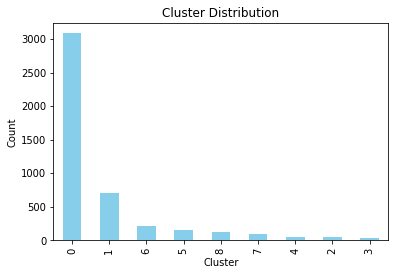

In [51]:
filtered_games_clu['Cluster_of_dev&Genres'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

In [52]:
filtered_games_clu.head()

,developers,genres,Cluster_release_yr,Cluster_of_dev&Genres
46,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,0
48,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],6,2
49,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],6,2
50,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,0
51,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,0


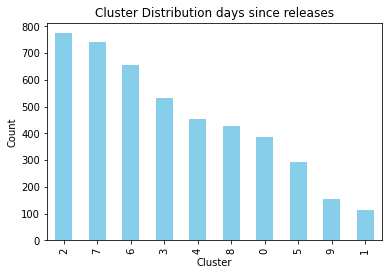

In [53]:
filtered_games_clu['Cluster_release_yr'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution days since releases')
plt.show()

In [54]:
# Loop through all rows to populate all 10 clusters based on days since released.
for clust_id in range(10):  
    clust_members = filtered_games_clu[filtered_games_clu['Cluster_release_yr'] == clust_id]  
    print(f"Cluster {clust_id}: {len(clust_members)} members")
    print(clust_members) 
    print("\n" + "-" * 50 + "\n")  

Cluster 0: 388 members
                  developers                                   genres  \
206              ['Creobit']                               ['Casual']   
237          ['Somer Games']                               ['Casual']   
243          ['Somer Games']                               ['Casual']   
250              ['Creobit']                               ['Casual']   
378      ['Choice of Games']  ['Adventure', 'Casual', 'Indie', 'RPG']   
...                      ...                                      ...   
81243  ['Sokpop Collective']                      ['Casual', 'Indie']   
81244  ['Sokpop Collective']                                ['Indie']   
81245  ['Sokpop Collective']      ['Indie', 'Simulation', 'Strategy']   
81254  ['Sokpop Collective']                   ['Adventure', 'Indie']   
81356  ['Sokpop Collective']                                ['Indie']   

       Cluster_release_yr  Cluster_of_dev&Genres  
206                     0                      0 